# ДЗ 1:

### Дизайн теста
1) Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

2) Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (0.5 балла)

3) На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (1.5 балла)

4) Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (1 балл)

### A/B тест
1) Представим что у нас прошел тест, используем те же самые данные за 2 недели

2) Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (0.5 балла)

3) Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (0.5 балла)

4) Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (1 балл)

5) Посчитайте результат такого теста и сделайте выводы (2 балла)

Еще 1 балл можно получить за хорошее и подробное объяснение каждого шага 

In [4]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import datetime
from statsmodels.stats.weightstats import ztest
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 20000)

/var/folders/06/5ck3wffn2f51181ns_qvff0r0000gq/T/ipykernel_3843/1381825117.py:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [165]:
import requests

# download dataset by chunks
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

req = requests.get(url, stream=True)

with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', 
                        unit_scale=True, position=0, leave=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

In [38]:
# Распаковываем архив из 3 файлов
import zipfile
 
with zipfile.ZipFile('data_kion.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [39]:
interactions = pd.read_csv('data_kion/interactions_df.csv')
users = pd.read_csv('data_kion/users.csv')
items = pd.read_csv('data_kion/items.csv')

In [40]:
interactions.head(5)

# user_id - уникальный идентификатор пользователя
# item_id - уникальный идентификатор контента
# last_watch_dt - последняя дата просмотра юзером определенного контента
# total_dur - суммарная продолжительность просмотра определенного контента юзером (в секундах)
# watched_pct - процент просмотренного контента от общей продолжительности

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [41]:
# предобработка данных
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions['user_id'] = interactions['user_id'].astype(str)

print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique():_}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique():_}")

Уникальных юзеров в interactions: 962_179
Уникальных айтемов в interactions: 15_706


#### 1) Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

In [42]:
max_date = interactions['last_watch_dt'].max()
max_date

datetime.date(2021, 8, 22)

In [43]:
week2 = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=13)]
week2 = week2.groupby('user_id', as_index=False).agg({'total_dur': sum})

In [44]:
week2

,user_id,total_dur
0,1,21172
1,1000,10744
2,1000000,32990
3,1000001,52
4,1000003,625
...,...,...
266076,999978,11172
266077,999987,27888
266078,999989,4563
266079,999990,997


/Users/victorbarbarich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

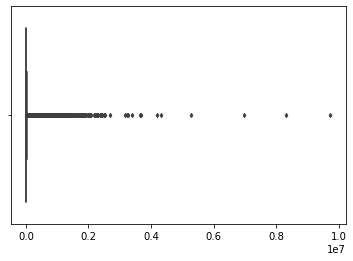

In [45]:
sns.boxplot(week2['total_dur'].values, fliersize=3)

In [46]:
print(week2.shape)
week2 = week2[(week2['total_dur'] < week2['total_dur'].std() * 3)]
print(week2.shape)

(266081, 2)
(262794, 2)


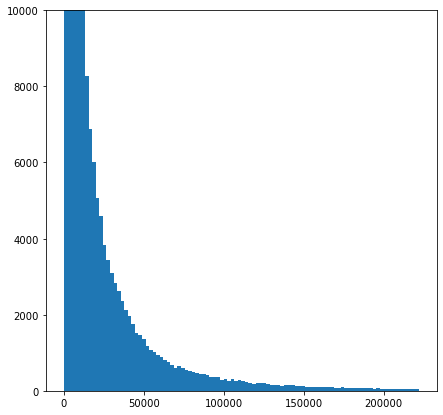

In [47]:
week2['total_dur'].hist(bins=100, figsize=(7,7))
plt.ylim([0, 10000])
plt.grid(False)

#### 2) Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (0.5 балла)


In [48]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode
    salt = os.urandom(8)
    
    return b64encode(salt).decode('ascii')


def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))


def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result

def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

In [49]:
# Делим на 2 равные группы 
def groups_splitter(df, columns, user_salt=None):
    
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt
    
    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()

In [176]:
correctness = []
values = []

for i in tqdm(range(1000), position=0, leave=True): # в дз используем 1000 итераций 
    
    new_df = groups_splitter(week2.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    
    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']
    
    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000) 
    values.append(sample_a_mean - sample_b_mean)
    
    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних
    
    correctness.append(not left_side <= 0 <= right_side)
    
    test_correctness = collections.Counter(correctness)
    
print(f'significance: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')

100%|█████████████████████████████████████| 1000/1000 [1:30:29<00:00,  5.43s/it]

significance: 5.1%


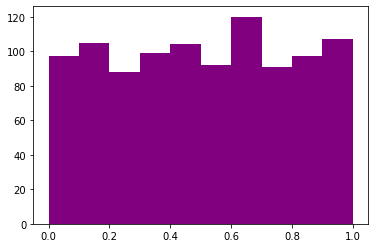

In [177]:
from scipy import stats as sts
p_values = [get_p_value(dist) for dist in values]
stat, p_value = sts.kstest(p_values, sts.uniform(loc=0.0, scale=1.0).cdf)

# f = px.histogram({'p_values': p_values}, x='p_values', 
#                  title=f'<b>Распределение p-values. Тест на равномерность: pv = {p_value:0.5f}')
# f.update_traces(xbins=dict(start=0, end=1))
# f.show()

plt.hist(p_values, bins=10, color='purple');

##### Сравнение: 

На семинаре:

significance: 5.0%
В дз:

significance: 5.1%
тест при добавлении еще одной недели не перестал быть корректным

#### 3) На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (1.5 балла)


In [144]:
# 1%

correctness = []
values = []

for i in tqdm(range(1000), position=0, leave=True): # в дз используем 1000 итераций 
    
    new_df = groups_splitter(week2.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    
    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']
    
    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000) * 1.01
    values.append(sample_a_mean - sample_b_mean)
    
    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних
    
    correctness.append(not left_side <= 0 <= right_side)
    
    test_correctness = collections.Counter(correctness)
    
print(f'power: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')

100%|█████████████████████████████████████| 1000/1000 [1:17:29<00:00,  4.65s/it]

power: 29.5%


In [145]:
# 3%

correctness = []
values = []

for i in tqdm(range(1000),  position=0, leave=True): # в дз используем 1000 итераций 
    
    new_df = groups_splitter(week2.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    
    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']
    
    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000) * 1.03
    values.append(sample_a_mean - sample_b_mean)
    
    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних
    
    correctness.append(not left_side <= 0 <= right_side)
    
    test_correctness = collections.Counter(correctness)
    
print(f'power: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')

100%|█████████████████████████████████████| 1000/1000 [1:08:34<00:00,  4.11s/it]

power: 98.8%


In [146]:
# 5%

correctness = []
values = []

for i in tqdm(range(100),  position=0, leave=True): # в дз используем 1000 итераций 
    
    new_df = groups_splitter(week2.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

    
    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']
    
    #bootstrap
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000) * 1.05
    values.append(sample_a_mean - sample_b_mean)
    
    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних
    
    correctness.append(not left_side <= 0 <= right_side)
    
    test_correctness = collections.Counter(correctness)
    
print(f'power: {test_correctness[1]/(test_correctness[1] + test_correctness[0])*100}%')

100%|█████████████████████████████████████████| 100/100 [06:53<00:00,  4.14s/it]

power: 100.0%


#### 4) Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (1 балл)

In [147]:
def get_mde(metric_vec, alpha=0.05, beta=0.2):
    
    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()
    
    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)
    
    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)
    
    return mde*100/metric_mean

In [148]:
get_mde(week2['total_dur'])

0.9604673863892595

#### 1) Представим что у нас прошел тест, используем те же самые данные за 2 недели

#### 2) Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (0.5 балла)

In [50]:
week2_2 = week2.copy()

In [51]:
week2_2['total_dur'] = (week2['total_dur'] > 500) * week2['total_dur']

#### 3) Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (0.5 балла)

In [52]:
new_df = groups_splitter(week2_2.copy(), columns=['user_id', 'total_dur', 'group'], 
                         user_salt='kiontestmodel20210805').drop_duplicates()


vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
vec_b = new_df[(new_df['group'] == 'B')]['total_dur']

#### 4) Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (1 балл)

In [53]:
tqdm.pandas()

In [54]:
q = np.quantile(vec_b, 0.9)

In [55]:
vec_b = vec_b.progress_apply(lambda x: x*1.1 if x > q else x)

100%|██████████████████████████████| 130863/130863 [00:00<00:00, 1006211.29it/s]


#### 5) Посчитайте результат такого теста и сделайте выводы (2 балла)

In [56]:
sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
sample_b_mean = calc_bootstrap_mean(vec_b, size=1000) 
diff = sample_a_mean - sample_b_mean

left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
                                              [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

print(not left_side <= 0 <= right_side)



True


In [57]:
get_p_value(diff)

0.0

In [60]:
np.mean(vec_b) / np.mean(vec_a)

1.0546492333055315

In [37]:
left_side, right_side 

(-1094.8699507655865, -625.885871872028)

Вывод:

Посчитала MDE на двух неделях ~0.96 

В группе Б среднее время просмотра увеличилось статистически значимо.

P-value < 0.05


95% доверительный интервал не содержит ноль